<a href="https://colab.research.google.com/github/Ritikaverma2021/Distracted_Driver/blob/main/VGG16_No__Extra_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers

In [ ]:
!nvidia-smi

Fri Sep 30 22:04:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
driver_details = pd.read_csv('/content/drive/MyDrive/mini_data_set/Copy of driver_imgs_list (1).csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [ ]:
# getting all the images
train_image = []
image_label = []


for i in range(10):
    print('folder C',i)
    imgs = os.listdir("/content/drive/MyDrive/mini_data_set/Train/C"+str(i))
    for j in range(len(imgs)):
        img_name = "/content/drive/MyDrive/mini_data_set/Train/C"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)

folder C 0
folder C 1
folder C 2
folder C 3
folder C 4
folder C 5
folder C 6
folder C 7
folder C 8
folder C 9


In [ ]:
# Randomly shuffling the images

import random
random.shuffle(train_image)

In [ ]:
# getting list of driver names

D = []
for features,labels,drivers in train_image:
    D.append(drivers)

## Deduplicating drivers

deduped = []

for i in D:
    if i not in deduped:
        deduped.append(i)
    

## selecting random drivers for the validation set
driv_selected = []
import random
driv_nums = random.sample(range(len(deduped)), 4)
for i in driv_nums:
    driv_selected.append(deduped[i])
driv_selected

['p002', 'p022', 'p066', 'p056']

In [ ]:
# training and splitting the training and testing data

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []
true_test =[]

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
        true_test.append(labels)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

4186 814
4186 814


In [ ]:
# Converting images to nparray. Encoding the Y.

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print(X_train.shape)
print(y_train.shape)

(4186, 224, 224, 3)
(4186, 10)


In [ ]:
# Defining the inputs for VGG model

from keras.layers import Input
vgg16_input = Input(shape=(224,224,3), name ='Image_input')

# The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

model_vgg16_conv = VGG16(weights='imagenet', include_top= False, input_tensor= vgg16_input)
model_vgg16_conv.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Use of the generated model 

from keras.models import Model

output_vgg16_conv = model_vgg16_conv(vgg16_input)

# Add the fully connected layers

x = Flatten(name ='flatten')(output_vgg16_conv)
x = Dense(10, activation='softmax', name='prediction')(x)

vgg16_pretrained = Model(vgg16_input,x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr=0.001)
vgg16_pretrained.compile(loss = 'categorical_crossentropy', optimizer=sgd,metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Image_input (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 prediction (Dense)          (None, 10)                250890    
                                                                 
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Running VGG with Image Augmentation

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose =1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30   
)

data_generator = datagen.flow(X_train, y_train, batch_size = 10)

vgg16_model = vgg16_pretrained.fit_generator(data_generator, steps_per_epoch= (len(X_train)/10), callbacks=[checkpointer, earlystopper],epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Epoch 1/25
419/418 [==============================] - ETA: 0s - loss: 2.2981 - accuracy: 0.1273
Epoch 1: val_loss improved from inf to 2.30514, saving model to vgg_weights_aug_setval_sgd.hdf5
418/418 [==============================] - 88s 211ms/step - loss: 2.2981 - accuracy: 0.1273 - val_loss: 2.3051 - val_accuracy: 0.1192
Epoch 2/25
419/418 [==============================] - ETA: 0s - loss: 2.2784 - accuracy: 0.1333
Epoch 2: val_loss improved from 2.30514 to 2.29940, saving model to vgg_weights_aug_setval_sgd.hdf5
418/418 [==============================] - 78s 185ms/step - loss: 2.2784 - accuracy: 0.1333 - val_loss: 2.2994 - val_accuracy: 0.1069
Epoch 3/25
419/418 [==============================] - ETA: 0s - loss: 2.2757 - accuracy: 0.1359
Epoch 3: val_loss improved from 2.29940 to 2.25671, saving model to vgg_weights_aug_setval_sgd.hdf5
418/418 [==============================] - 75s 179ms/step - loss: 2.2757 - accuracy: 0.1359 - val_loss: 2.2567 - val_accuracy: 0.1732
Epoch 4/25
419

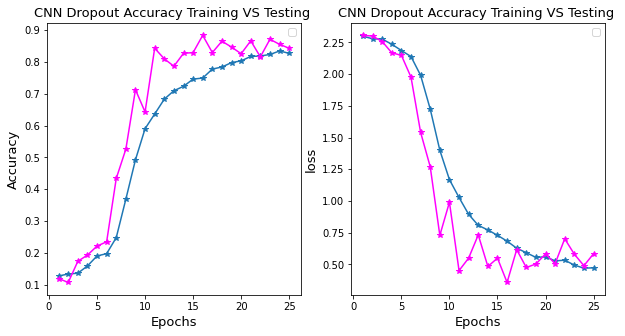

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy'])+1), vgg16_pretrained.history.history['accuracy'],linestyle= 'solid', marker ='*')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy'])+1), vgg16_pretrained.history.history['val_accuracy'],linestyle= 'solid', marker ='*', color = 'magenta')
axes[0].set_xlabel('Epochs', fontsize =13)
axes[0].set_ylabel('Accuracy', fontsize = 13)
axes[0].set_title('CNN Dropout Accuracy Training VS Testing ', fontsize =13)
axes[0].legend(loc = 'best')

axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss'])+1), vgg16_pretrained.history.history['loss'],linestyle= 'solid', marker ='*')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss'])+1), vgg16_pretrained.history.history['val_loss'],linestyle= 'solid', marker ='*', color ='magenta')
axes[1].set_xlabel('Epochs', fontsize =13)
axes[1].set_ylabel('loss', fontsize = 13)
axes[1].set_title('CNN Dropout Accuracy Training VS Testing ', fontsize =13)
axes[1].legend(loc = 'best')

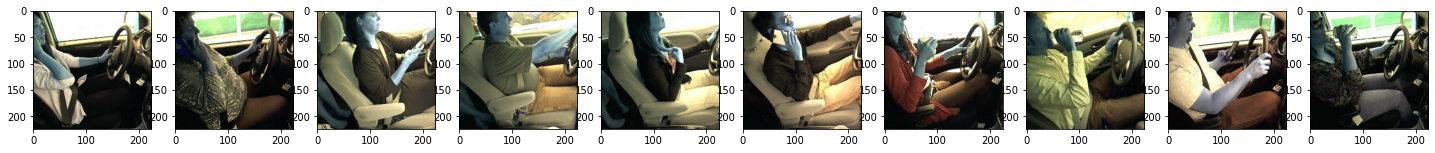

In [ ]:
# Labels is the image array
test_images =[]
i=0
fig,ax =plt.subplots(1,10, figsize=(25,25))

files = os.listdir('/content/drive/MyDrive/mini_data_set/Test')
nums = np.random.randint(low=1, high =len(files), size =10)
for i in range(10):
  #print('Image Number : ', i)
  img = cv2.imread('/content/drive/MyDrive/mini_data_set/Test/'+ files[nums[i]])
  img = img [50:, 120:-50]
  img = cv2.resize(img,(224,224))
  test_images.append(img)
  ax[i].imshow(img, cmap='gray')
  plt.show

In [ ]:
test =[]
 
for img in test_images:
  test.append(img)

vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')

test = np.array(test).reshape(-1,224,224,3)
prediction = vgg16_pretrained.predict(test)

In [ ]:
prediction[7]

array([2.35689329e-10, 1.79666145e-07, 9.46679393e-06, 3.96295887e-12,
       4.56408407e-06, 3.47690376e-10, 8.98761928e-01, 1.39807410e-09,
       1.01223215e-01, 5.81137101e-07], dtype=float32)

In [ ]:
tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

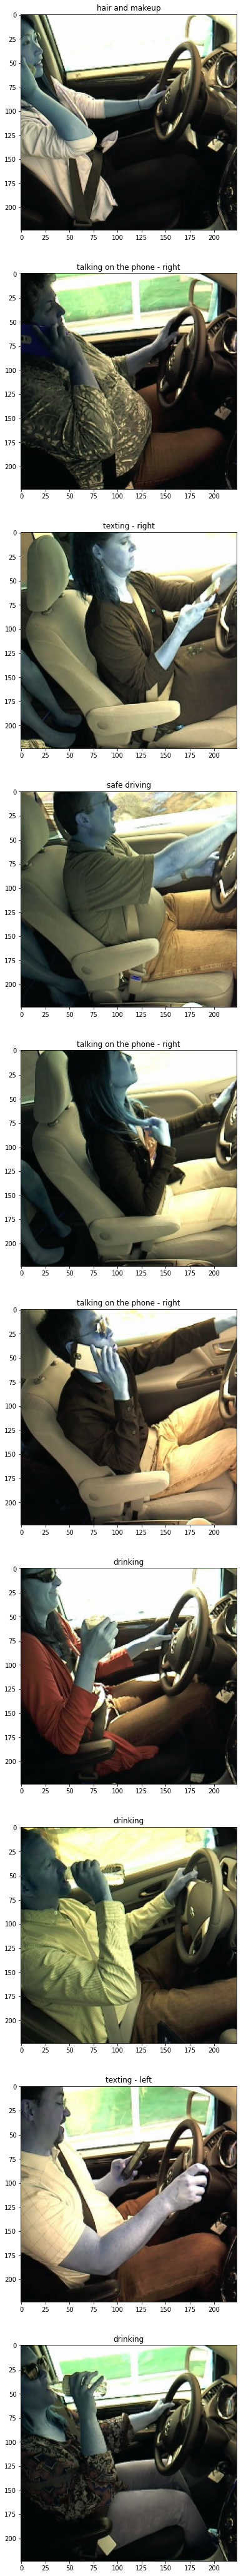

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(10, 1, figsize = (75,75))

for i in range(10):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    

In [ ]:
# labels is the image array


model5_prediction = []
model5_pred_class = []

model5_prediction = vgg16_pretrained.predict(X_test)
print('Images Predicted until now:',len(model5_prediction))


for i in range(len(model5_prediction)):
    model5_pred_class.append(np.where(model5_prediction[i] == np.amax(model5_prediction[i]))[0][0])

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix   
print('The accuracy of this model over validation set is:',accuracy_score(true_test,model5_pred_class))
confusion_matrix(true_test,model5_pred_class)

Images Predicted until now: 814
The accuracy of this model over validation set is: 0.8832923832923832


array([[67,  2,  0,  1,  0,  0,  0,  1,  0,  1],
       [ 0, 80,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 73,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 81,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 82,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 70,  0,  3,  3,  3],
       [ 0,  2,  0,  0,  1,  0, 69,  0, 18,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 84,  1,  3],
       [ 1,  0,  2,  0,  0,  0,  3, 18, 58,  0],
       [14,  1,  2,  3,  0,  0,  0,  6,  2, 55]])

In [ ]:
from sklearn.metrics import log_loss

lgloss = log_loss(y_test, model5_prediction, eps=1e-15, normalize=True, sample_weight=None, labels=None)

print('The log loss from this model is:',round(lgloss,2))

The log loss from this model is: 0.36
